In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

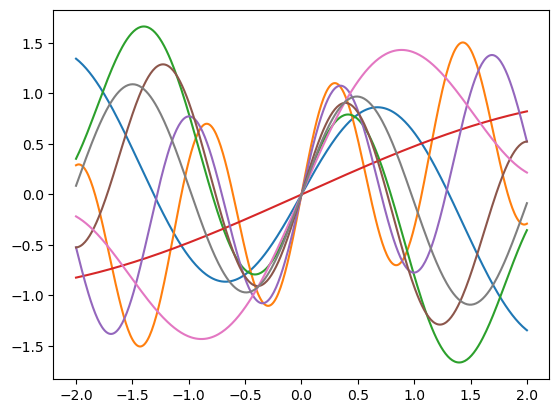

In [2]:
from src.sine_data import SineData
import matplotlib.pyplot as plt

sine_data_test = SineData(testing=True)

batch = sine_data_test.generate_curves(batch_size=8)

for i in range(8):
    x = batch.target_x[i].flatten()
    y = batch.target_y[i].flatten()
    plt.plot(x.numpy(), y.numpy())
plt.show()

In [40]:
import torch
import torch.nn as nn
from src.inp import InformedNeuralProcess
"""
                 x_size: int = 2,
                 y_size: int = 1,
                 r_size: int = 64,
                 z_size: int = 64,
                 xK_size: int = 3,
                 k_size: int = 128,
                 h_size_dec: int = 128,
                 h_size_enc_det: int = 128,
                 h_size_enc_know: int = 128,
                 h_size_agg: int = 128,
                 N_h_layers_dec: int = 3,
                 N_h_layers_enc_know_phi: int = 2,
                 N_h_layers_enc_know_rho: int = 2,
                 N_h_layers_enc_det: int = 6,
                 N_h_layers_agg: int = 3,
"""
model = InformedNeuralProcess(
    x_size=1,
    y_size=1,
    r_size=128,
    z_size=128,
    xK_size=3,
    k_size=128,
    h_size_dec=128,
    h_size_enc_det=128,
    h_size_enc_know=128,
    h_size_agg=128,
    N_h_layers_dec=3,
    N_h_layers_enc_know_phi=2,
    N_h_layers_enc_know_rho=2,
    N_h_layers_enc_det=6,
    N_h_layers_agg=3
)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

data = SineData()

InformedNeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (deterministic_encoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): Identity()
    )
  )
  (knowledge_encoder): KnowledgeEncoder(
    (phi): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (

In [41]:
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

def loss_function(pred_dist: Normal, 
                  target_y: torch.Tensor,
                  posterior: Normal,
                  prior: Normal):

    batch_size, num_targets, _ = target_y.shape
    log_p = pred_dist.log_prob(target_y).sum(-1)
    # assert log_p.shape[-1] == 1
    # log_p = log_p.squeeze(-1)

    kl_div = torch.sum(kl_divergence(posterior, prior), dim=-1, keepdim=True)

    loss = -torch.mean(log_p - kl_div / num_targets)
    return loss, -log_p.sum() / (num_targets*batch_size)


Iter: 0, Loss 1.189904, NLL 1.189904


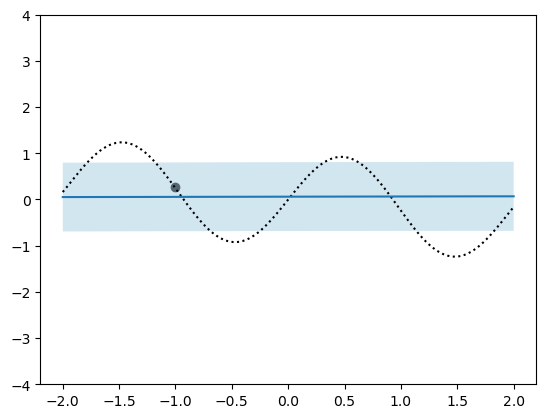

Iter: 100, Loss 1.252414, NLL 1.240474
Iter: 200, Loss 0.956235, NLL 0.936801
Iter: 300, Loss 0.827297, NLL 0.814194
Iter: 400, Loss 0.742105, NLL 0.718471
Iter: 500, Loss 0.721716, NLL 0.708306
Iter: 600, Loss 0.678530, NLL 0.676146
Iter: 700, Loss 0.629775, NLL 0.593728
Iter: 800, Loss 0.459328, NLL 0.425228
Iter: 900, Loss 0.455068, NLL 0.425153
Iter: 1000, Loss 0.606719, NLL 0.598689


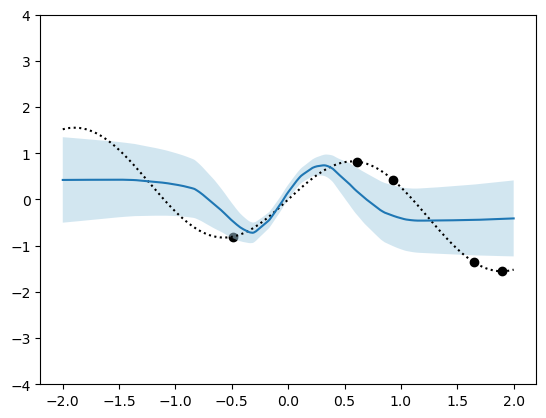

Iter: 1100, Loss 0.151191, NLL 0.087466
Iter: 1200, Loss 0.456313, NLL 0.424456
Iter: 1300, Loss 0.603098, NLL 0.551170
Iter: 1400, Loss 0.704063, NLL 0.389370
Iter: 1500, Loss 0.389573, NLL 0.344038
Iter: 1600, Loss 0.430321, NLL 0.299153
Iter: 1700, Loss 0.310313, NLL 0.291621
Iter: 1800, Loss 0.050021, NLL -0.090428
Iter: 1900, Loss 0.003654, NLL -0.048652
Iter: 2000, Loss -0.127548, NLL -0.221476


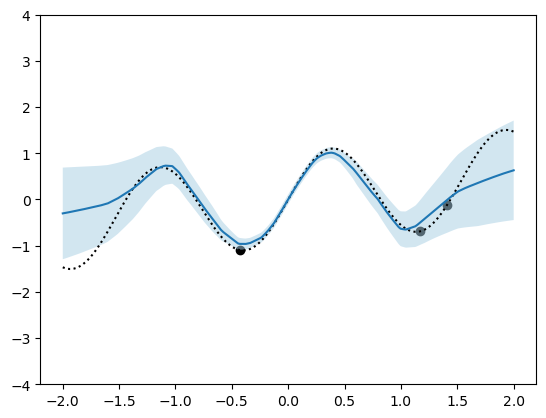

Iter: 2100, Loss -0.077737, NLL -0.183764
Iter: 2200, Loss 0.268607, NLL -0.137619
Iter: 2300, Loss -0.137911, NLL -0.238523
Iter: 2400, Loss -0.098220, NLL -0.309427
Iter: 2500, Loss 0.043233, NLL 0.008942
Iter: 2600, Loss -0.040612, NLL -0.130801
Iter: 2700, Loss -0.335144, NLL -0.414368
Iter: 2800, Loss -0.380941, NLL -0.517595
Iter: 2900, Loss -0.281774, NLL -0.459427
Iter: 3000, Loss -0.245150, NLL -0.350920


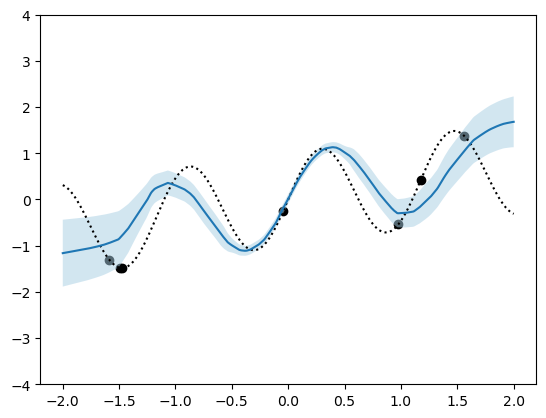

Iter: 3100, Loss -0.361355, NLL -0.507277
Iter: 3200, Loss -0.337744, NLL -0.379885
Iter: 3300, Loss -0.150514, NLL -0.617299
Iter: 3400, Loss -0.250242, NLL -0.285549
Iter: 3500, Loss -0.272914, NLL -0.443570
Iter: 3600, Loss -0.086021, NLL -0.476253
Iter: 3700, Loss -0.184961, NLL -0.361584
Iter: 3800, Loss -0.495255, NLL -0.597750
Iter: 3900, Loss -0.455896, NLL -0.592644
Iter: 4000, Loss -0.625850, NLL -0.683302


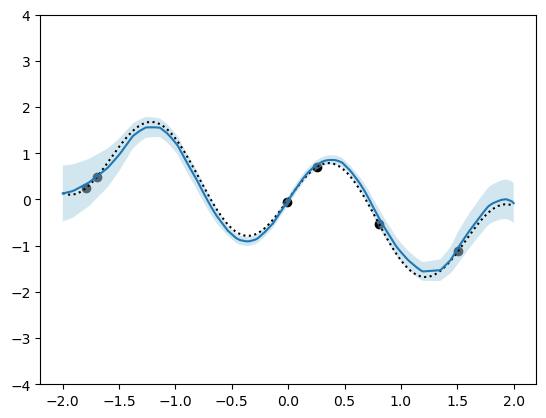

Iter: 4100, Loss -0.531391, NLL -0.567448
Iter: 4200, Loss -0.511421, NLL -0.723680
Iter: 4300, Loss -0.382832, NLL -0.425515
Iter: 4400, Loss -0.373951, NLL -0.520564
Iter: 4500, Loss -0.661221, NLL -0.712314
Iter: 4600, Loss -0.522733, NLL -0.602130
Iter: 4700, Loss -0.433136, NLL -0.676699
Iter: 4800, Loss -0.477909, NLL -0.771109
Iter: 4900, Loss -0.384071, NLL -0.481896
Iter: 5000, Loss -0.552540, NLL -0.630703


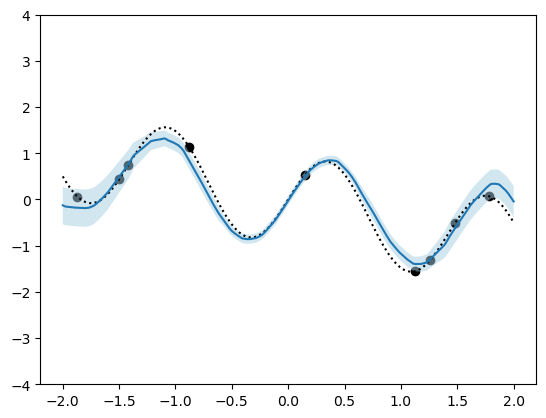

Iter: 5100, Loss -0.206473, NLL -0.467013
Iter: 5200, Loss -0.460117, NLL -0.560691
Iter: 5300, Loss -0.651343, NLL -0.683869
Iter: 5400, Loss -0.361754, NLL -0.412501
Iter: 5500, Loss -0.683026, NLL -0.774367
Iter: 5600, Loss -0.535858, NLL -0.667270
Iter: 5700, Loss -0.247300, NLL -0.487751
Iter: 5800, Loss -0.323641, NLL -0.646379
Iter: 5900, Loss -0.371810, NLL -0.734803
Iter: 6000, Loss -0.768925, NLL -0.840475


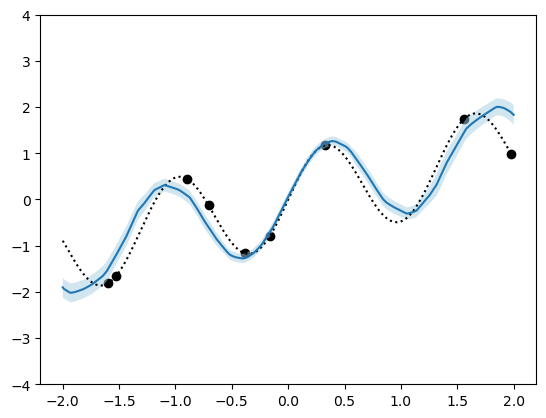

Iter: 6100, Loss -0.689106, NLL -0.764393
Iter: 6200, Loss -0.499347, NLL -0.548523
Iter: 6300, Loss -0.513784, NLL -0.651925
Iter: 6400, Loss -0.117769, NLL -0.424415
Iter: 6500, Loss -0.241744, NLL -0.479891
Iter: 6600, Loss -0.352817, NLL -0.599802
Iter: 6700, Loss -0.658454, NLL -0.723368
Iter: 6800, Loss -0.732158, NLL -0.797587
Iter: 6900, Loss -0.742929, NLL -0.836813
Iter: 7000, Loss -0.687056, NLL -0.796496


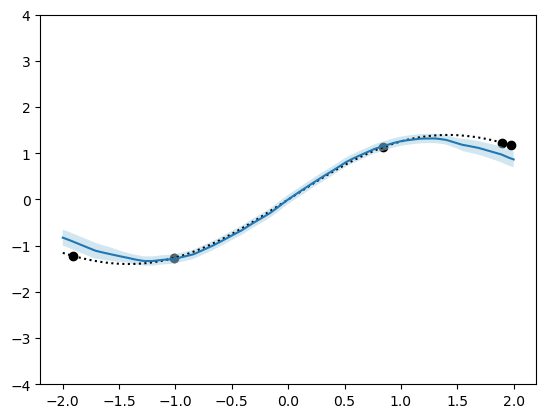

Iter: 7100, Loss -0.670215, NLL -0.766780
Iter: 7200, Loss -0.846621, NLL -0.869465
Iter: 7300, Loss -0.670667, NLL -0.720978
Iter: 7400, Loss -0.450866, NLL -0.704732
Iter: 7500, Loss -0.565170, NLL -0.672426
Iter: 7600, Loss -0.775128, NLL -0.859207
Iter: 7700, Loss -0.377640, NLL -0.538360
Iter: 7800, Loss -0.698500, NLL -0.802324
Iter: 7900, Loss -0.822894, NLL -0.988269
Iter: 8000, Loss -0.909852, NLL -0.950016


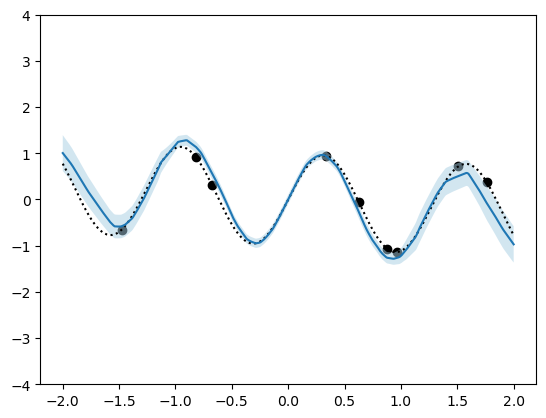

Iter: 8100, Loss -0.499815, NLL -0.530644
Iter: 8200, Loss -0.820641, NLL -0.918746
Iter: 8300, Loss -0.548525, NLL -0.604303
Iter: 8400, Loss -0.545942, NLL -0.632469
Iter: 8500, Loss -0.699560, NLL -0.923324
Iter: 8600, Loss -0.757285, NLL -0.972561
Iter: 8700, Loss -0.223257, NLL -0.475092
Iter: 8800, Loss -0.751952, NLL -0.796168
Iter: 8900, Loss -0.616854, NLL -0.792404
Iter: 9000, Loss -0.569170, NLL -0.889489


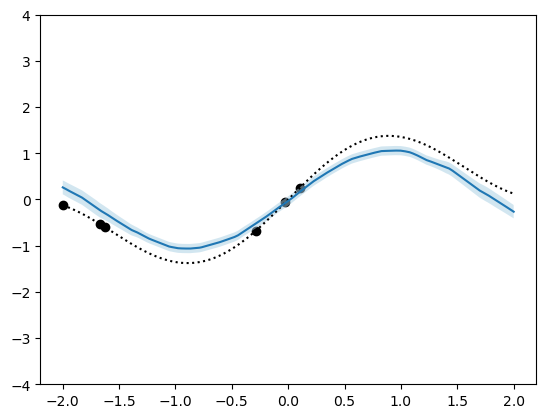

Iter: 9100, Loss -0.531896, NLL -0.829284
Iter: 9200, Loss -0.574111, NLL -0.629701
Iter: 9300, Loss -0.529339, NLL -0.860701
Iter: 9400, Loss -0.469353, NLL -0.675032
Iter: 9500, Loss -0.627048, NLL -0.821825
Iter: 9600, Loss -0.325622, NLL -0.478931
Iter: 9700, Loss -0.824947, NLL -0.877860
Iter: 9800, Loss -0.588874, NLL -0.728031
Iter: 9900, Loss -0.859970, NLL -0.908348
Iter: 10000, Loss -0.560782, NLL -0.830327


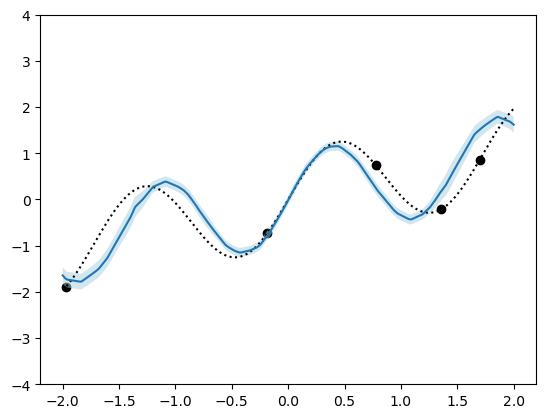

In [42]:
from src.plot import plot_predictive

model.training = True
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


train_loss = []
for iter in range(10000+1):
    batch = data.generate_curves(batch_size=16)

    context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
    target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)

    optimiser.zero_grad()

    
    p_y_pred, q_z_target, q_z_context = model(context_x, context_y, None, target_x, target_y)


    loss, nll = loss_function(p_y_pred, target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 100 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f}, NLL {nll:.6f}")
    if iter % 1000 == 0:
        with torch.no_grad():
            model.training = False
            batch = data.generate_curves(batch_size=1, testing=True)
            context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
            target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)
            p_y_pred = model(context_x, context_y, None, target_x, target_y)
            mu = p_y_pred.mean
            sigma = p_y_pred.stddev
            plot_predictive(context_x, context_y, target_x, target_y, mu, sigma)
            model.training = True




In [47]:
num_z_samples = 32
num_test_batches = 16
batch_losses = []
with torch.no_grad():
    model.training = False

    for _ in range(num_test_batches):
        batch_loss = 0
        batch = data.generate_curves(batch_size=64, testing=True)
        context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
        target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)

        for _ in range(num_z_samples):
            p_y_pred = model(context_x, context_y, None, target_x, target_y)
            mu = p_y_pred.mean
            sigma = p_y_pred.stddev

            log_p = p_y_pred.log_prob(target_y).sum(dim=(-1,-2)) # Shape (batch_size, num_targets)
            batch_loss += log_p.mean()
        batch_losses.append(batch_loss / num_z_samples)

print(f"Test Loss: {torch.stack(batch_losses).mean().item():.6f}")

Test Loss: -3720.610352


In [53]:
informed_model = InformedNeuralProcess(
    x_size=1,
    y_size=1,
    r_size=128,
    z_size=128,
    xK_size=1,
    k_size=128,
    h_size_dec=128,
    h_size_enc_det=128,
    h_size_enc_know=128,
    h_size_agg=128,
    N_h_layers_dec=3,
    N_h_layers_enc_know_phi=2,
    N_h_layers_enc_know_rho=2,
    N_h_layers_enc_det=6,
    N_h_layers_agg=3
)
informed_model.to(device)


InformedNeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (deterministic_encoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): Identity()
    )
  )
  (knowledge_encoder): KnowledgeEncoder(
    (phi): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (

Iter: 0, Loss 1.379242, NLL 1.379242


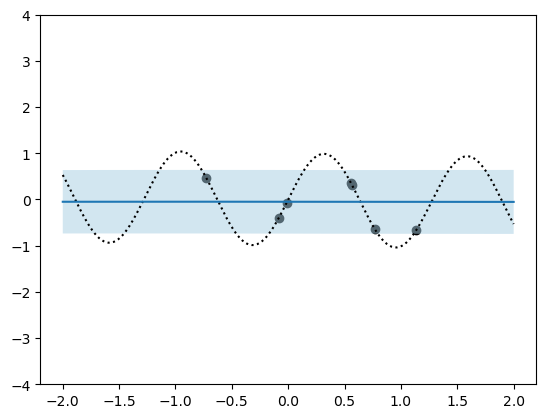

Iter: 100, Loss 1.065223, NLL 1.062609
Iter: 200, Loss 0.891143, NLL 0.877834
Iter: 300, Loss 0.853842, NLL 0.848359
Iter: 400, Loss 0.846901, NLL 0.837123
Iter: 500, Loss 0.429840, NLL 0.423088
Iter: 600, Loss 0.612881, NLL 0.593132
Iter: 700, Loss 0.369568, NLL 0.359706
Iter: 800, Loss 0.538292, NLL 0.532727
Iter: 900, Loss 0.348645, NLL 0.341952
Iter: 1000, Loss 0.704667, NLL 0.619020


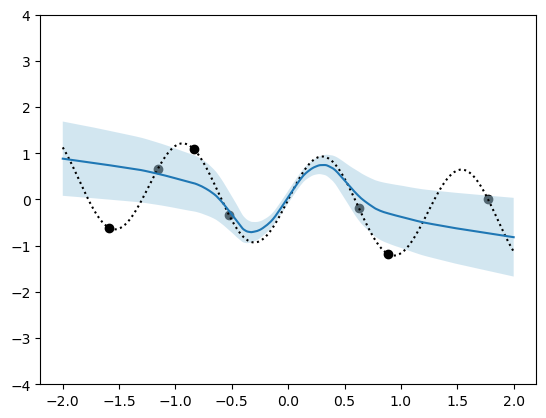

Iter: 1100, Loss 0.090957, NLL 0.073336
Iter: 1200, Loss 0.153001, NLL 0.133450
Iter: 1300, Loss 0.321205, NLL 0.227052
Iter: 1400, Loss 0.075404, NLL 0.046365
Iter: 1500, Loss 0.096376, NLL 0.045758
Iter: 1600, Loss -0.172106, NLL -0.275763
Iter: 1700, Loss -0.181035, NLL -0.207178
Iter: 1800, Loss -0.023917, NLL -0.180053
Iter: 1900, Loss -0.236844, NLL -0.281502
Iter: 2000, Loss 0.034584, NLL -0.059918


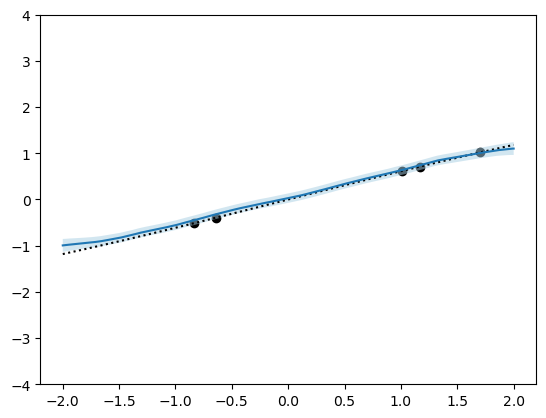

Iter: 2100, Loss -0.445491, NLL -0.542235
Iter: 2200, Loss -0.296547, NLL -0.360569
Iter: 2300, Loss -0.599306, NLL -0.618755
Iter: 2400, Loss -0.365339, NLL -0.432657
Iter: 2500, Loss -0.361618, NLL -0.408260
Iter: 2600, Loss -0.330019, NLL -0.506106
Iter: 2700, Loss -0.101721, NLL -0.168250
Iter: 2800, Loss -0.613511, NLL -0.809748
Iter: 2900, Loss -0.729442, NLL -0.746809
Iter: 3000, Loss -0.306733, NLL -0.342004


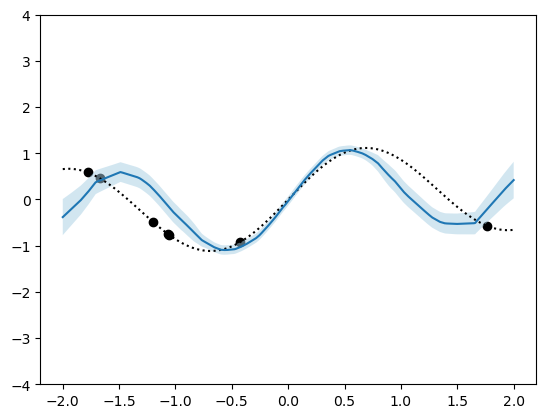

Iter: 3100, Loss -0.248059, NLL -0.288652
Iter: 3200, Loss -0.201201, NLL -0.226618
Iter: 3300, Loss -0.293438, NLL -0.445646
Iter: 3400, Loss -0.312107, NLL -0.589096
Iter: 3500, Loss -0.295284, NLL -0.344362
Iter: 3600, Loss -0.585213, NLL -0.643030
Iter: 3700, Loss -0.351815, NLL -0.389915
Iter: 3800, Loss -0.612667, NLL -0.830951
Iter: 3900, Loss -0.254298, NLL -0.387583
Iter: 4000, Loss -0.644119, NLL -0.736188


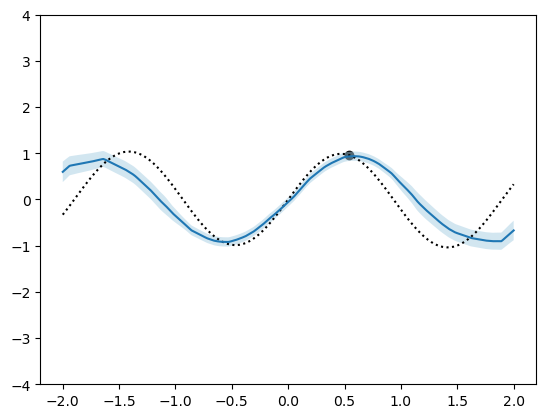

Iter: 4100, Loss -0.044473, NLL -0.406229
Iter: 4200, Loss -0.828438, NLL -0.866999
Iter: 4300, Loss -0.582040, NLL -0.624663
Iter: 4400, Loss -0.568792, NLL -0.797950
Iter: 4500, Loss -0.965193, NLL -0.990109
Iter: 4600, Loss -0.671251, NLL -0.687322
Iter: 4700, Loss -0.325551, NLL -0.429320
Iter: 4800, Loss -0.456366, NLL -0.548626
Iter: 4900, Loss -0.587385, NLL -0.628941
Iter: 5000, Loss -0.571170, NLL -0.805003


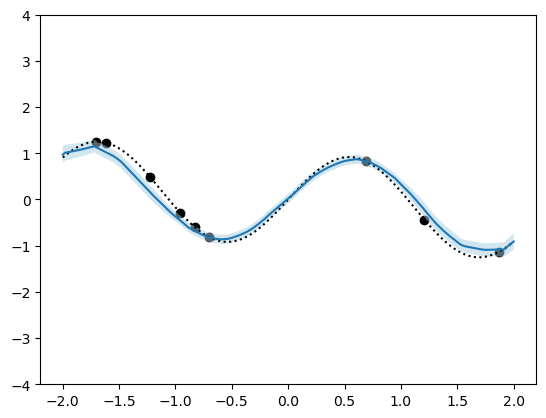

Iter: 5100, Loss -0.736411, NLL -0.804856
Iter: 5200, Loss -0.637851, NLL -0.819933
Iter: 5300, Loss -0.840115, NLL -0.895870
Iter: 5400, Loss -0.573622, NLL -0.802248
Iter: 5500, Loss -0.524322, NLL -0.579637
Iter: 5600, Loss -0.506378, NLL -0.584023
Iter: 5700, Loss -0.531342, NLL -0.714971
Iter: 5800, Loss -0.279674, NLL -0.379617
Iter: 5900, Loss -0.643052, NLL -0.856328
Iter: 6000, Loss -0.778837, NLL -0.806354


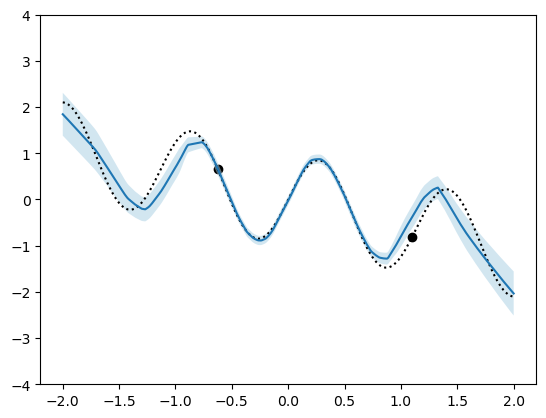

Iter: 6100, Loss -0.804590, NLL -0.862023
Iter: 6200, Loss -0.694803, NLL -0.775306
Iter: 6300, Loss -0.600905, NLL -0.784187
Iter: 6400, Loss -0.633387, NLL -0.766051
Iter: 6500, Loss -0.776290, NLL -0.858214
Iter: 6600, Loss -0.543482, NLL -0.599252
Iter: 6700, Loss -0.423358, NLL -0.635851
Iter: 6800, Loss -0.624871, NLL -0.649433
Iter: 6900, Loss -0.463492, NLL -0.744283
Iter: 7000, Loss -0.292743, NLL -0.542500


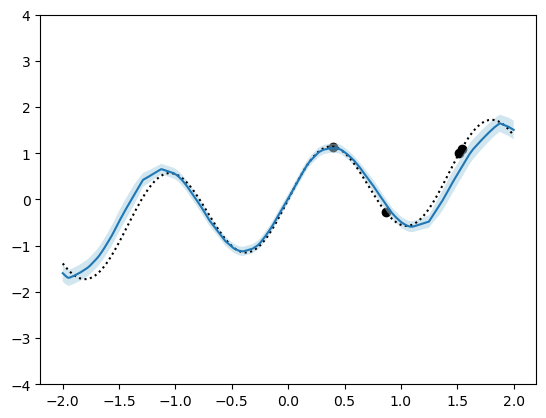

Iter: 7100, Loss -0.829323, NLL -0.870703
Iter: 7200, Loss -0.920002, NLL -0.961909
Iter: 7300, Loss -0.737166, NLL -0.881117
Iter: 7400, Loss -0.973503, NLL -1.002424
Iter: 7500, Loss -0.992308, NLL -1.018470
Iter: 7600, Loss -0.669199, NLL -0.881607
Iter: 7700, Loss -0.967367, NLL -1.029908
Iter: 7800, Loss -0.923055, NLL -0.998349
Iter: 7900, Loss -0.658010, NLL -0.848059
Iter: 8000, Loss -0.790409, NLL -0.832396


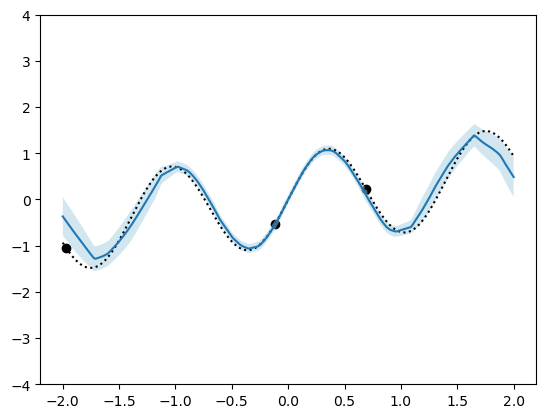

Iter: 8100, Loss -0.737392, NLL -0.820130
Iter: 8200, Loss -0.825478, NLL -0.924543
Iter: 8300, Loss -0.660640, NLL -0.750060
Iter: 8400, Loss -0.881995, NLL -0.930250
Iter: 8500, Loss -0.773809, NLL -0.800037
Iter: 8600, Loss -0.768662, NLL -0.927806
Iter: 8700, Loss -0.723701, NLL -0.922651
Iter: 8800, Loss -0.547884, NLL -0.590854
Iter: 8900, Loss -0.808607, NLL -0.839500
Iter: 9000, Loss -0.735516, NLL -0.789688


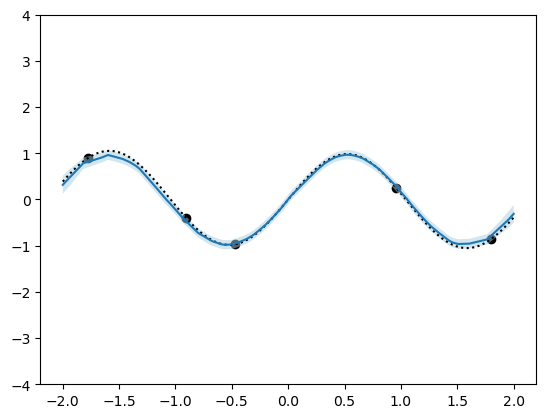

Iter: 9100, Loss -0.905567, NLL -0.951271
Iter: 9200, Loss -0.800117, NLL -0.854371
Iter: 9300, Loss -0.827069, NLL -0.919846
Iter: 9400, Loss -1.042579, NLL -1.074562
Iter: 9500, Loss -0.956511, NLL -1.025101
Iter: 9600, Loss -0.828389, NLL -0.866818
Iter: 9700, Loss -0.931456, NLL -0.966207
Iter: 9800, Loss -0.536370, NLL -0.827240
Iter: 9900, Loss -0.980377, NLL -1.003085
Iter: 10000, Loss -0.982568, NLL -1.027152


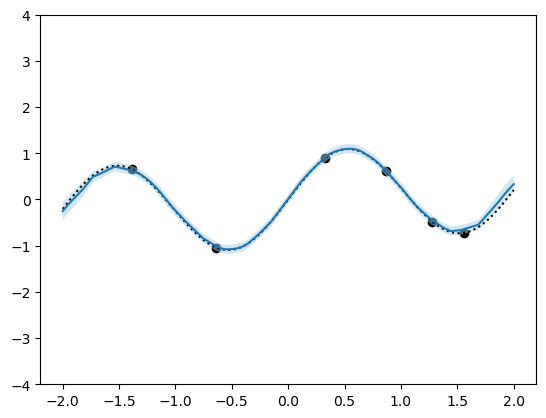

In [54]:
informed_model.training = True
optimiser = torch.optim.Adam(informed_model.parameters(), lr=1e-3)


train_loss = []
for iter in range(10000+1):
    batch = data.generate_curves(batch_size=16)

    context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
    target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)

    knowledge = batch.a.to(device)
    optimiser.zero_grad()

    
    p_y_pred, q_z_target, q_z_context = informed_model(context_x, context_y, knowledge, target_x, target_y)


    loss, nll = loss_function(p_y_pred, target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 100 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f}, NLL {nll:.6f}")
    if iter % 1000 == 0:
        with torch.no_grad():
            informed_model.training = False
            batch = data.generate_curves(batch_size=1, testing=True)
            context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
            target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)
            knowledge = batch.a.to(device)
            p_y_pred = informed_model(context_x, context_y, knowledge, target_x, target_y)
            mu = p_y_pred.mean
            sigma = p_y_pred.stddev
            plot_predictive(context_x, context_y, target_x, target_y, mu, sigma)
            informed_model.training = True

In [60]:
informed_batch_losses = []
with torch.no_grad():
    informed_model.training = False

    for _ in range(num_test_batches):
        batch_loss = 0
        batch = data.generate_curves(batch_size=64, testing=True)
        context_x, context_y = batch.context_x.to(device), batch.context_y.to(device)
        target_x, target_y = batch.target_x.to(device), batch.target_y.to(device)
        knowledge = batch.a.to(device)
        for _ in range(num_z_samples):
            p_y_pred = informed_model(context_x, context_y, knowledge, target_x, target_y)
            mu = p_y_pred.mean
            sigma = p_y_pred.stddev

            log_p = p_y_pred.log_prob(target_y).sum(dim=(-1,-2)) # Shape (batch_size, num_targets)
            batch_loss += log_p.mean()
        informed_batch_losses.append(batch_loss / num_z_samples)
print(f"Test Loss: {torch.stack(informed_batch_losses).mean().item():.6f}")

Test Loss: -1741.231201
